# Visualize model predictions

Ensure that samples entered are in the test set or validation set

In [79]:
import os
import sys
from pytorch_lightning import Trainer
import albumentations as A
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import numpy as np

sys.path.append('models/')
from UNet_mateuszbuda import UNet_m
from loss import DiceLoss
from loss import DiceLoss2

sys.path.append('data/')
from CTDataSet import CTDicomSlices, DatasetManager
from CustomTransforms import Window
from CustomTransforms import Imagify

sys.path.append('tests')
from test_CTDataSet import plot_slices_and_mask

### Plotting function

In [82]:
def plot_img_and_mask(img, prediction, mask, text = ""):
    mask = mask * 255 // 4
    prediction = prediction * 255 // 4
    
    img = img.numpy()
    mask = mask.numpy()
    prediction = prediction.numpy()

    img_pred = np.stack((img + prediction, img - prediction, img - prediction), axis=2)
    img_pred = img_pred.clip(0, 255).astype("uint8")

    img_mask = np.stack((img - mask, img + mask, img - mask), axis=2)
    img_mask = img_mask.clip(0, 255).astype("uint8")
    
    fig = plt.figure(figsize=(21,21))
    cols, rows = 3, 1
    
    fig.patch.set_facecolor('white')
    
    fig.add_subplot(rows, cols, 1)
    plt.title('CT Slice')
    plt.imshow(img, cmap='gray')
    
    fig.add_subplot(rows, cols, 2)
    plt.title('Prediction')
    plt.imshow(img_pred)
    
    fig.add_subplot(rows, cols, 3)
    plt.title('Ground truth')
    plt.imshow(img_mask)
    
    plt.show()

### Some constants

In [3]:
WL = 50
WW = 200

img_size = 256

def to_float(x, **kwargs):
    return x.astype('float32')

### Create the relevant transforms

In [4]:
img_mask_tsfm = A.Compose([A.Resize(img_size, img_size)],
            additional_targets={"image1": 'image', "mask1": 'mask'})

### Build the relevant datasets

In [5]:
main_dir = "../model_runs"
model_name = "100_epochs_32_features_unet"
model_dir = "{}/{}".format(main_dir, model_name)
checkpoint_f = 'epoch=91.ckpt'

dataset = "../organized_dataset_2"

dsm = DatasetManager.load_train_val_test(dataset, "{}/train.txt".format(model_dir), "{}/val.txt".format(model_dir), "{}/test.txt".format(model_dir))

train_dicoms, val_dicoms, test_dicoms = dsm.get_dicoms() # DICOM glob is preset in the class file

test_ds = CTDicomSlices(test_dicoms, img_and_mask_transform = img_mask_tsfm)

test_dl = DataLoader(test_ds, batch_size=1, num_workers = 0, shuffle=True)

In [6]:
model = UNet_m.load_from_checkpoint("{}/lightning_logs/version_0/checkpoints/{}".format(model_dir, checkpoint_f))

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0505/dicoms/8.dcm',)
Dice score 2 is: 25.000%


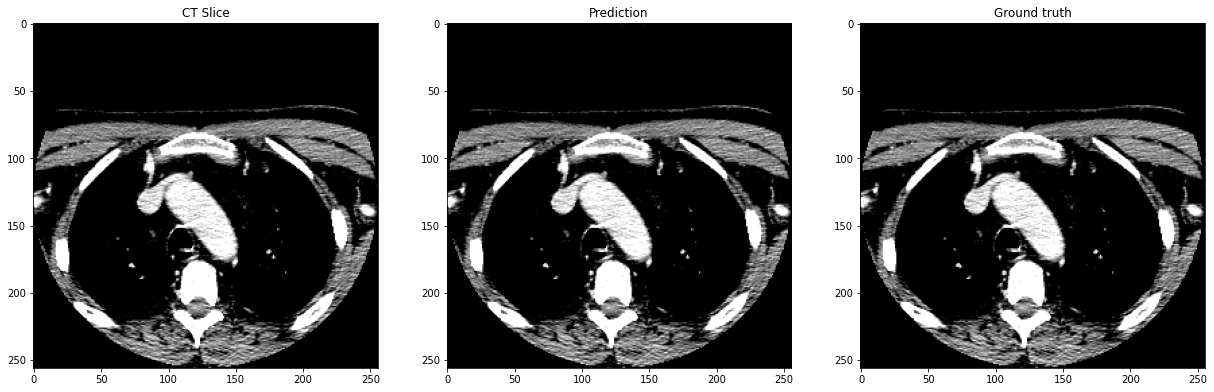

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0547/dicoms/154.dcm',)
Dice score 2 is: 0.110%


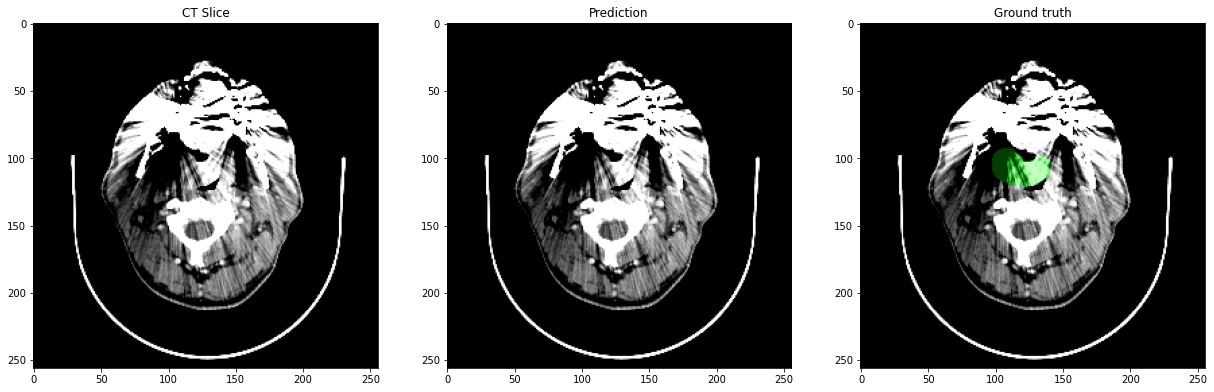

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0621/dicoms/179.dcm',)
Dice score 2 is: 12.500%


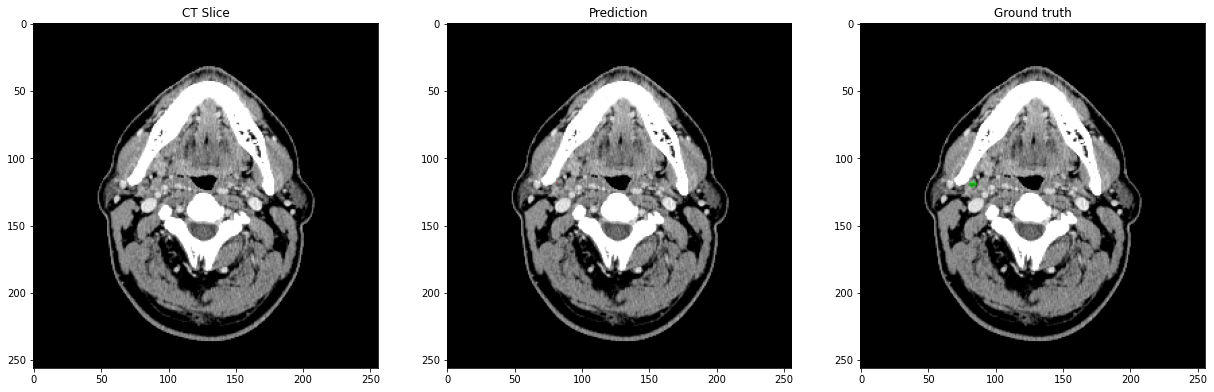

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0399/dicoms/145.dcm',)
Dice score 2 is: 90.221%


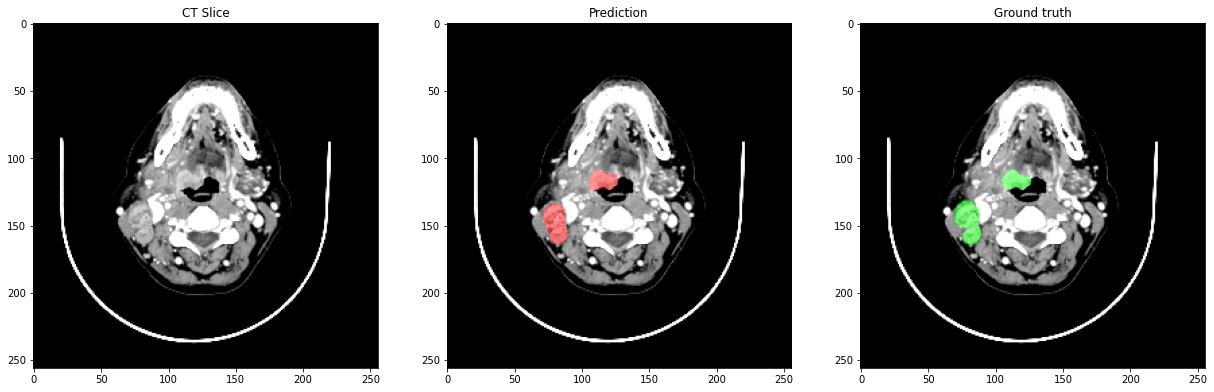

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0558/dicoms/114.dcm',)
Dice score 2 is: 88.449%


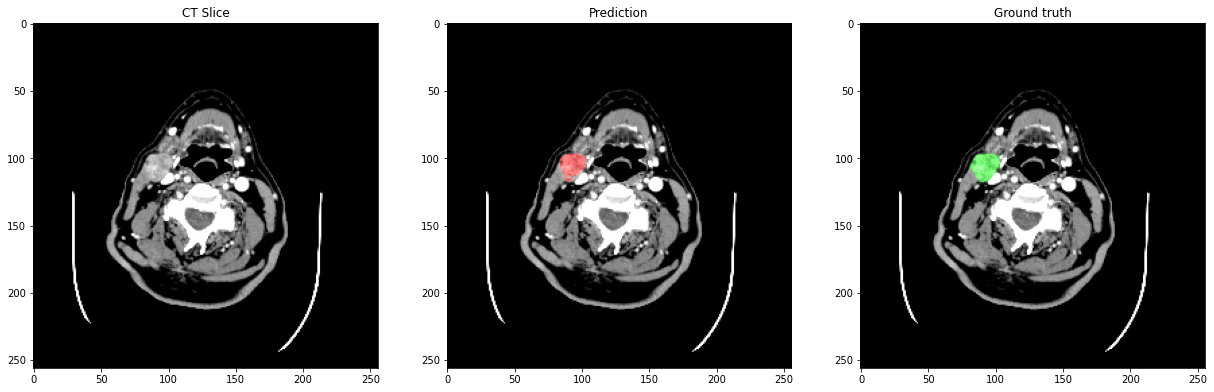

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0390/dicoms/178.dcm',)
Dice score 2 is: 84.641%


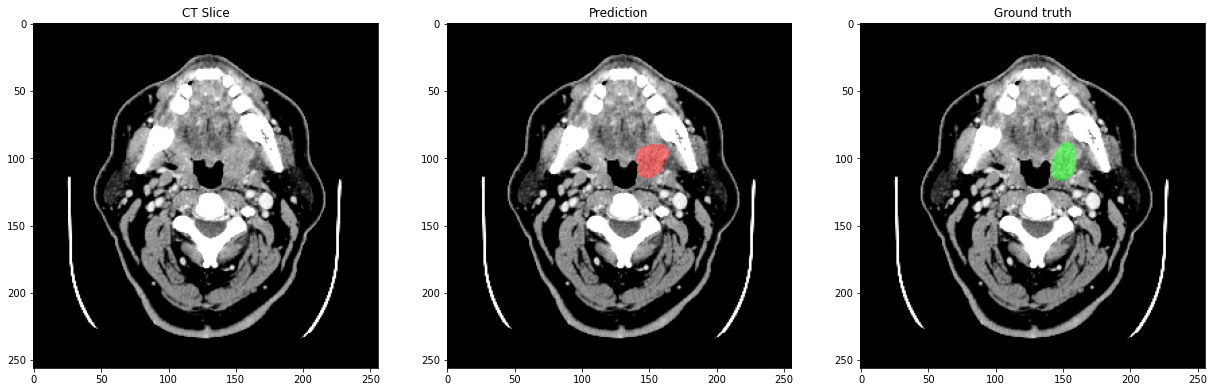

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0575/dicoms/143.dcm',)
Dice score 2 is: 79.192%


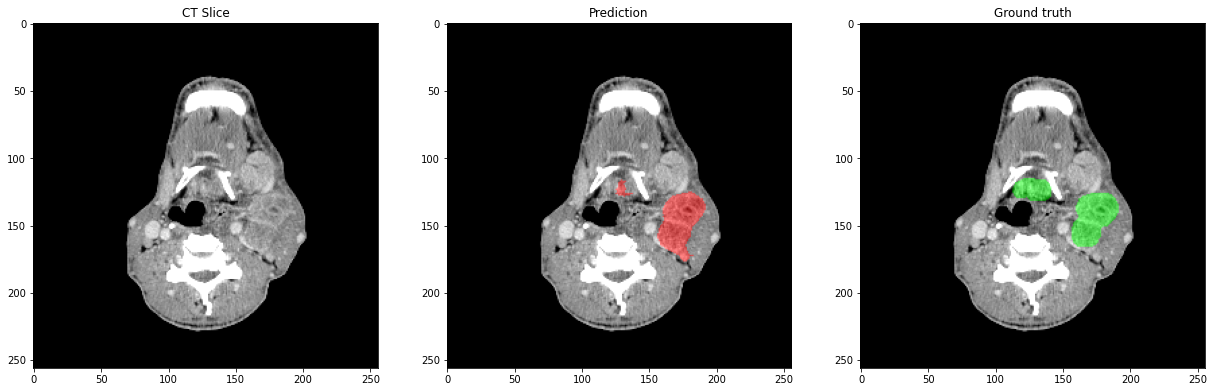

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0522/dicoms/145.dcm',)
Dice score 2 is: 58.285%


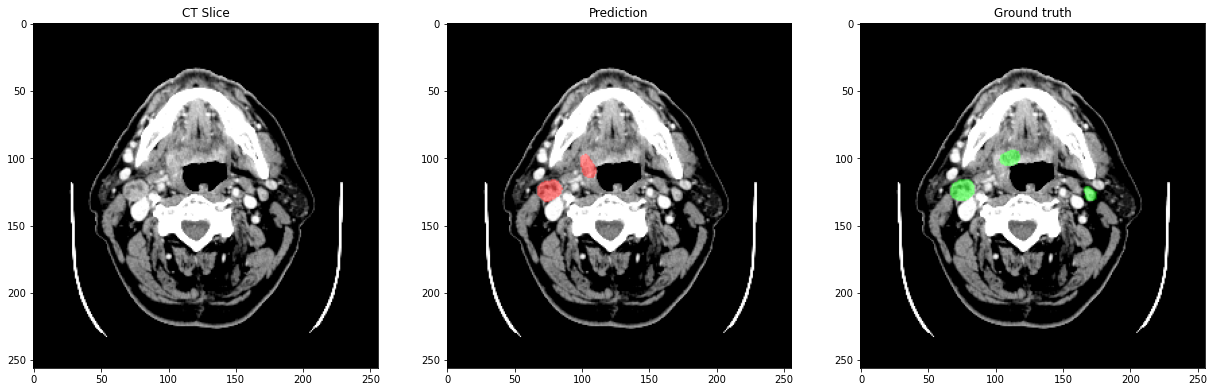

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0511/dicoms/42.dcm',)
Dice score 2 is: 0.671%


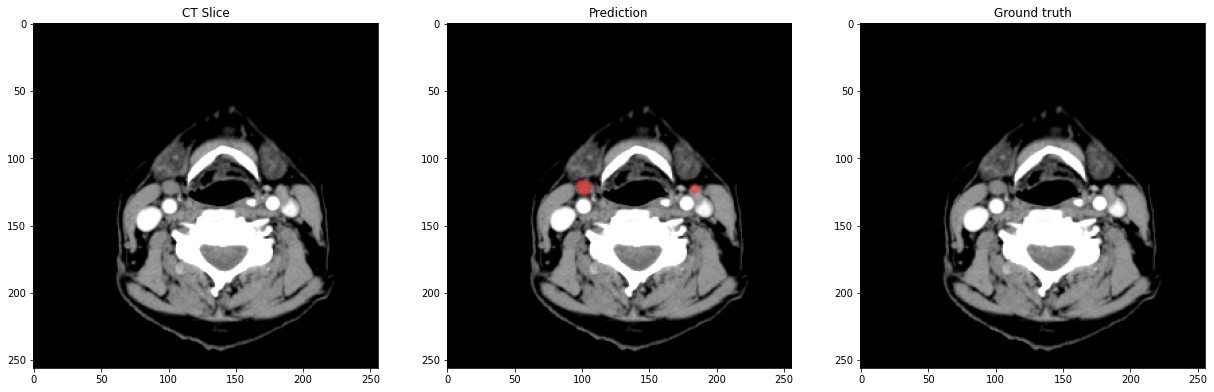

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0376/dicoms/118.dcm',)
Dice score 2 is: 3.571%


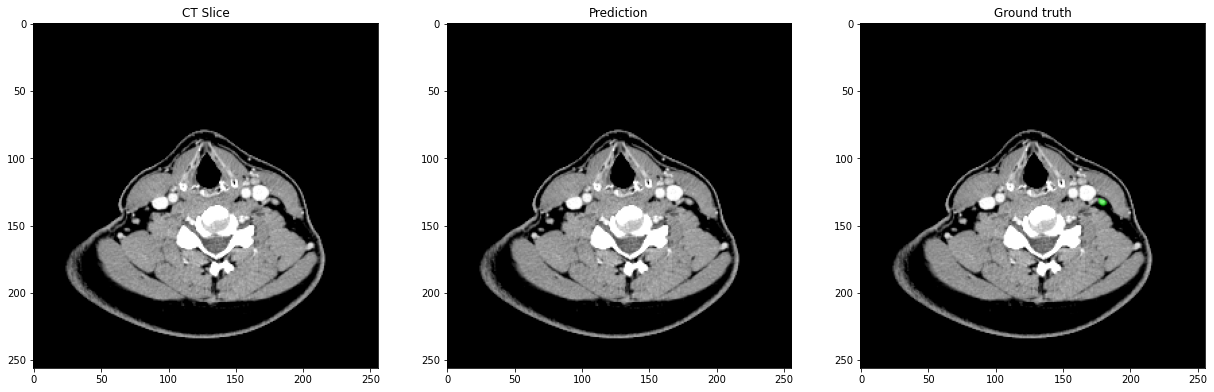

Model WL: 50 - WW: 200
Input file is: ('../organized_dataset_2/HNSCC-01-0504/dicoms/155.dcm',)
Dice score 2 is: 89.406%


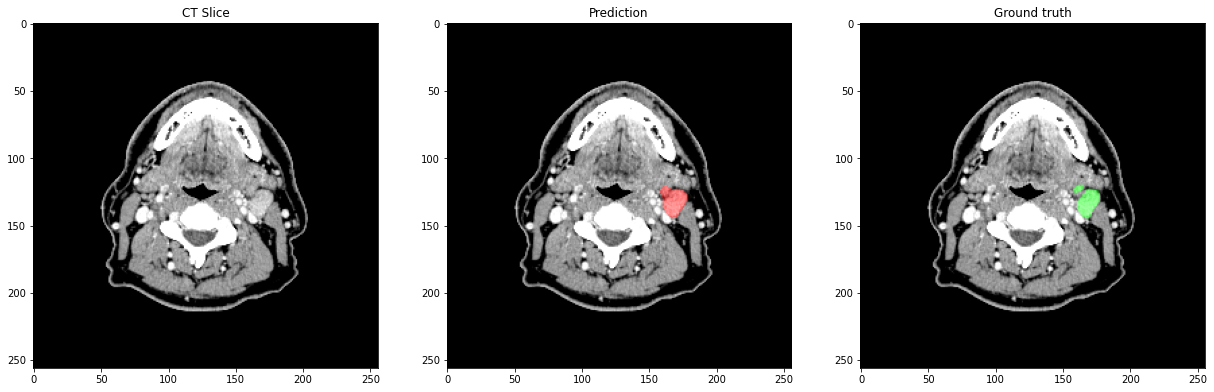

In [84]:
loss = DiceLoss()
loss2 = DiceLoss2()

max = 10
for i, (slices, mask, img_path, slice_n) in enumerate(test_dl):   
    slices, mask = model.preprocessing(slices, mask, b_h_w_c=True)
    
    y_pred = model(slices)
    
    if (torch.sum(mask) == 0 and torch.sum(torch.round(y_pred)) == 0):
        max += 1
        continue
    
    print("Model WL: {} - WW: {}".format(model.WL, model.WW))
    print("Input file is: {}".format(img_path))
    print("Dice score 2 is: {:.3f}%".format((1 - loss2(torch.round(y_pred[:,0,:,:]), mask)) * 100))

    plot_img_and_mask(slices[0,1,:,:], torch.round(y_pred[0,0,:,:].detach()), mask[0], slice_n)
    
    if i >= max:
        break

In [ ]:
slices, mask, img_path, slice_n = next(iter(test_dl))

mask = mask.type(torch.float32)
y_pred = model(slices)

print(mask.shape)
print(torch.round(y_pred[:,0,:,:]).shape)

print(pl.metrics.functional.dice_score(torch.round(y_pred[:,0,:,:]), mask))
print(loss(torch.round(y_pred[:,0,:,:]), mask))